In [ ]:
# definicia modelu

import torch.nn as nn
class BERTClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)  

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  
        out = self.dropout(pooled_output)
        return self.classifier(out)


In [2]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")


In [ ]:
pip install transformers


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer
import pandas as pd

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# nacitanie renovacej a testovacej sady datasetu
train_df = pd.read_csv('toxic_eng/train.csv')  
test_df = pd.read_csv('toxic_eng/test.csv')  

train_texts = train_df['comment_text'].tolist()
train_labels = train_df['toxic'].tolist()
test_texts = test_df['comment_text'].tolist()
test_labels = test_df['toxic'].tolist()

# inicializacia tokenizera
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# nastavime si maximalnu dlzku sekvencie
MAX_LEN = 128

# vytvorenie datasetov
train_dataset = TextDataset(train_texts, train_labels, tokenizer, max_len=MAX_LEN)
test_dataset = TextDataset(test_texts, test_labels, tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [35]:
from tqdm import tqdm
def save_checkpoint(model, optimizer, epoch, checkpoint_dir, model_name):
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_epoch{epoch+1}.pt")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_path)
    print(f"Checkpoint uložený do: {checkpoint_path}")

def train_bert_with_tqdm_and_checkpoints(model, train_loader, criterion, optimizer, device, num_epochs, checkpoint_dir, model_name):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch in loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item())

        accuracy = correct / total
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

        save_checkpoint(model, optimizer, epoch, checkpoint_dir, model_name)


In [36]:
def evaluate_bert_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    test_loader_tqdm = tqdm(test_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in test_loader_tqdm:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")


In [37]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
from transformers import AutoModel, AutoTokenizer
import os
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = BERTClassifier().to(device)

optimizer = torch.optim.AdamW(bert_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

print("Training BERT with checkpoints...")
train_bert_with_tqdm_and_checkpoints(bert_model, train_loader, criterion, optimizer, device, num_epochs=5, checkpoint_dir="checkpointss", model_name="bert_model")

evaluate_bert_model(bert_model, test_loader, device)


Training BERT with checkpoints...


Epoch 1/5: 100%|██████████| 3750/3750 [1:35:20<00:00,  1.53s/it, loss=0.122]  


Epoch 1, Loss: 510.6281, Accuracy: 0.9463
Checkpoint uložený do: checkpointss/bert_model_epoch1.pt


Epoch 4/5: 100%|██████████| 3750/3750 [1:35:05<00:00,  1.52s/it, loss=0.00239] 


Epoch 4, Loss: 109.4991, Accuracy: 0.9894
Checkpoint uložený do: checkpointss/bert_model_epoch4.pt


Epoch 5/5: 100%|██████████| 3750/3750 [1:35:30<00:00,  1.53s/it, loss=0.0504]  


Epoch 5, Loss: 70.5036, Accuracy: 0.9932
Checkpoint uložený do: checkpointss/bert_model_epoch5.pt


Test Accuracy: 0.9545


In [39]:
tokenizer.save_pretrained("bert_tokenizer")


('bert_tokenizer/tokenizer_config.json',
 'bert_tokenizer/special_tokens_map.json',
 'bert_tokenizer/vocab.txt',
 'bert_tokenizer/added_tokens.json',
 'bert_tokenizer/tokenizer.json')

In [40]:
torch.save(bert_model.state_dict(), "bert_model.pth")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

test_dataset = TextDataset(test_texts, test_labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=8)


def evaluate_bert_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    print("\n Vysledky klasifikacie:")
    print(classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()
    
evaluate_bert_model(bert_model, test_loader, device)


In [46]:
print(classification_report(y_true, y_pred, target_names=["non-toxic", "toxic"]))


NameError: name 'y_true' is not defined

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import softmax

def evaluate_bert_model(model, test_loader, device, test_texts, tokenizer):
    model.eval()
    y_true = []
    y_pred = []
    texts_output = []

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = softmax(outputs, dim=1)
            predictions = torch.argmax(probs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

            start = i * test_loader.batch_size
            end = start + len(predictions)
            batch_texts = test_texts[start:end]

            for text, true_label, pred_label, prob in zip(
                batch_texts,
                labels.cpu().numpy(),
                predictions.cpu().numpy(),
                probs.cpu().numpy()
            ):
                if len(texts_output) < 100:
                    confidence = prob[pred_label]
                    tokens = tokenizer.tokenize(text)
                    token_ids = tokenizer.convert_tokens_to_ids(tokens)
                    texts_output.append((text, true_label, pred_label, confidence, tokens, token_ids))

    print(classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    print("\n Predikcie po vetách (max 100):")
    label_names = ["Netoxická", "Toxická"]
    for text, true_label, pred_label, confidence, tokens, token_ids in texts_output:
        print(f'Veta: "{text}"')
        print(f'Tokeny: {tokens}')
        print(f'Token IDs: {token_ids}')
        print(f'Skutočný: {label_names[true_label]} | Predikovaný: {label_names[pred_label]} ({confidence:.2%})\n')

evaluate_bert_model(bert_model, test_loader, device, test_texts, tokenizer)


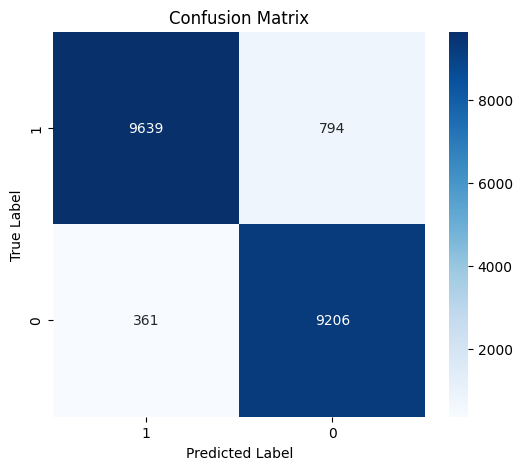

In [ ]:
#vytvorenie matice len tak ak potrebujem dat do grafickej podoby
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

TP = 9639
FP = 794
FN = 361
TN = 9206

cm = np.array([[TP, FP],
               [FN, TN]])

labels = ['1', '0']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
